# Data Cleaning and EDA

### Import packages and data


In [109]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# from xgboost import XGBClassifier
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import descartes

In [179]:
#import training data 
df_train = pd.read_csv('../../../data/raw/train_set_values.csv')
df_labels = pd.read_csv('../../../data/raw/train_set_labels.csv')

#merge labels and features:
df_train= pd.merge(df_train, df_labels, on='id')


functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64


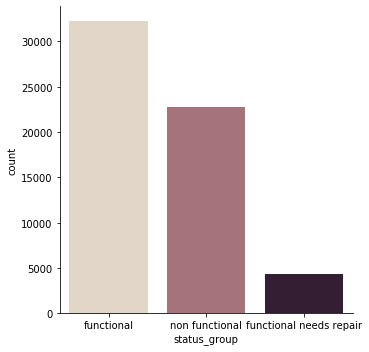

In [71]:
#check the target classes counts:
print(df_train.status_group.value_counts())
sns.catplot(x="status_group", kind="count", palette="ch:.25", data=df_train)

Seems like 'functional' and 'non-functional' are almost balanced enough.... but 'functional needs repair' has a big class inbalance. We'll need to address this later at some point in time... maybe through upsampling, or maybe we could just lump it into non-functional. 

### Clean NaN Values

In [72]:
#find out which features have NAN values. 
df_train.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

There are many features with NaN values. We'll need to address each of these on a case by case basis as far as what we want to do with the empty values. 

In [73]:
#start with 'scheme_name' since there are so many empty values. 
print(len(df_train.scheme_name.value_counts()))
df_train.scheme_name.value_counts()

2696


K                            682
None                         644
Borehole                     546
Chalinze wate                405
M                            400
                            ... 
Mtunguruzi                     1
LENCH TARAMAI                  1
Mradi wa maji wa Ndongosi      1
Mondoros water scheme          1
Kalemela Mwaloni               1
Name: scheme_name, Length: 2696, dtype: int64

In [74]:
#According to the feature descriptions this is the same
#as scheme_management, so lets check this:
print(len(df_train.scheme_management.value_counts()))
df_train.scheme_management.value_counts()

12


VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

Ok, scheme_name and scheme_management seem to be different, but because there are over 2669 values for scheme_name and there are 28166 missing values, droping that column will likely not reduce in any loss in predictive power. 

In [75]:
df_train = df_train.drop('scheme_name', axis=1)

In [76]:
#functions to aid in data cleaning

def values_to_keep(df, column, number_of_values_to_keep, verbose = False):
    """
    This function takes in a pandas dataframe, the column of concern, and a number of categories to reduce the number 
    of unique values to. It prints the number of unique values in the column and the top value counts of each. It also
    returns a list of categorical values to retain. 
    """
    number_of_values_to_keep = number_of_values_to_keep-1
    
    if verbose == True:
        print(len(df[column].value_counts()))
        print(df[column].value_counts())
        
        list_of_values = df[column].value_counts()
        list_of_values_to_keep = list(list_of_values[0:number_of_values_to_keep].index)
    else:
        
        list_of_values = df[column].value_counts()
        list_of_values_to_keep = list(list_of_values[0:number_of_values_to_keep].index)
        
    return list_of_values_to_keep

def reduce_categorical_values(df, column_name, number_of_values_to_keep):
    
    """
    This function reduces the number of unique categorical values in a specific dataframe's column. It keeps the top 
    'number_of_values_to_keep' values, and casts the other remaining categorical values as "Other". This function 
    returns a Dataframe with the altered categorical values. Using this function can reduce the amount of dummy columns
    needed whilst maintaining the information contained in the column.
    """
    #use helper function to create a list of cat. values to keep
    list_of_classes_to_keep = values_to_keep(df, column_name, number_of_values_to_keep)
    
    #use subsetting to test if cat. value is in list, if not cast it to 'Other'    "~" means isNOTin 
    df[column_name].loc[~df[column_name].isin(list_of_classes_to_keep)]='Other'
    
    return df

def plot_feature(df, pred_col, target_variable, height = 10):
    
    """
    Produces a categorical bar plot visualizing the number of observations in each target category for each predicitve 
    value. 
    """
    
    sns.catplot(y=pred_col, hue=target_variable, kind="count",
            palette="ch:.25", edgecolor=".6",
            data=df, height= height); 

# def reduce_categorical_values(df, column_name, number_of_values_to_keep):
    
#     """
#     This function reduces the number of unique categorical values in a specific dataframe's column. It keeps the top 
#     'number_of_values_to_keep' values, and casts the other remaining categorical values as "Other". This function 
#     returns a Dataframe with the altered categorical values.
#     """
#     list_of_classes_to_keep = values_to_keep(df, column_name, number_of_values_to_keep)
#     for value in df[column_name].unique():
#         if value in list_of_classes_to_keep:
#             pass
#         else:
#             df.loc[df[column_name]== value]="Other"
#     return df


In [77]:
#ok, now lets check the rest in descending order starting with 'funder':
#Lets find the number of categorical values in 'funder', and the top 10 values:
values_to_keep(df_train, 'funder', 10, verbose=True)

1897
Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Godii                        1
Matata Selemani              1
Upendo Primary School        1
Mzee Ngwatu                  1
Municipal Council            1
Name: funder, Length: 1897, dtype: int64


['Government Of Tanzania',
 'Danida',
 'Hesawa',
 'Rwssp',
 'World Bank',
 'Kkkt',
 'World Vision',
 'Unicef',
 'Tasaf']

'funder' has 1897 unique categories, ~3000 NaN values, but clearly the majority of the water pumps come from a few of the different funders. it doesnt seem right to just fill the NaNs with the mode. There are also way to many to OneHotEncode. Lets instead turn it into 10 categories: the top 9 frequently occuring values,  and one "other" category which will include all other categories + the NaN values.

In [78]:
reduce_categorical_values(df_train, 'funder', 10)

/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Other,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Other,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Other,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Other,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Other,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
59396,27263,4700.0,2011-05-07,Other,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
59397,37057,0.0,2011-04-11,Other,0,NaN,34.017087,-8.750434,Mashine,0,...,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59398,31282,0.0,2011-03-08,Other,0,Musa,35.861315,-6.378573,Mshoro,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


10
Other                     37810
Government Of Tanzania     9084
Danida                     3114
Hesawa                     2202
Rwssp                      1374
World Bank                 1349
Kkkt                       1287
World Vision               1246
Unicef                     1057
Tasaf                       877
Name: funder, dtype: int64


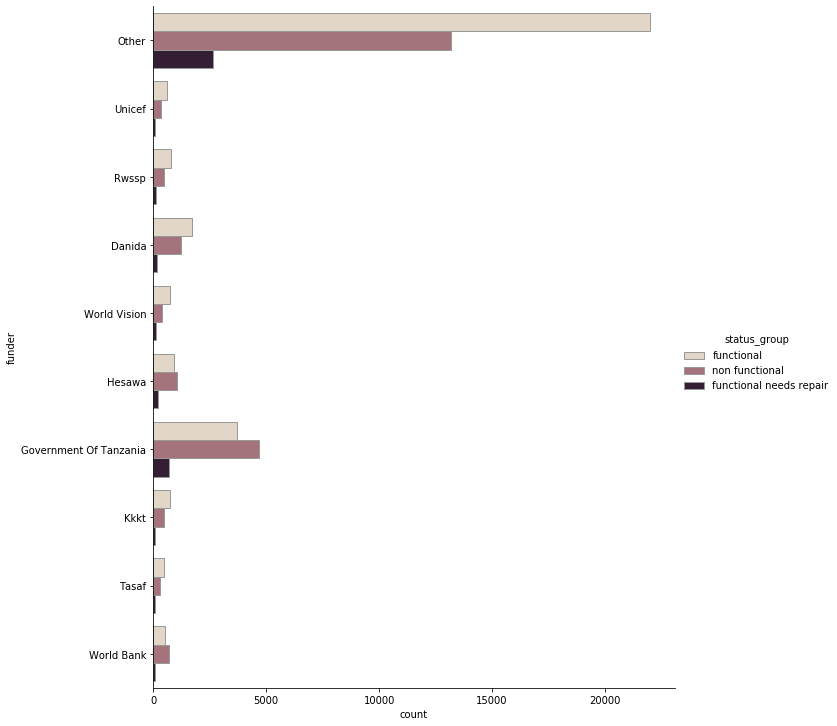

In [79]:
print(len(df_train.funder.value_counts()))
print(df_train.funder.value_counts())
plot_feature(df_train, 'funder', 'status_group')

Looking at the above chart, it seems like funder could be a good predictor sice there are particular funders with significant numbers of disfunctional pumps.  

In [80]:
#Now for 'installer'.Lets find the number of categorical values in 'installer', and the top 10 values:
values_to_keep(df_train, 'installer', 10, verbose= True)


2145
DWE                     17402
Government               1825
RWE                      1206
Commu                    1060
DANIDA                   1050
                        ...  
George mtoto company        1
Elina                       1
TCRS/ TWESA                 1
IN                          1
world vision                1
Name: installer, Length: 2145, dtype: int64


['DWE', 'Government', 'RWE', 'Commu', 'DANIDA', 'KKKT', 'Hesawa', '0', 'TCRS']

In [81]:
#reduce the categorical values of 'installer' to 10, and fill NaN values:
df_train = reduce_categorical_values(df_train, 'installer', 10)

10
Other         33635
DWE           17402
Government     1825
RWE            1206
Commu          1060
DANIDA         1050
KKKT            898
Hesawa          840
0               777
TCRS            707
Name: installer, dtype: int64


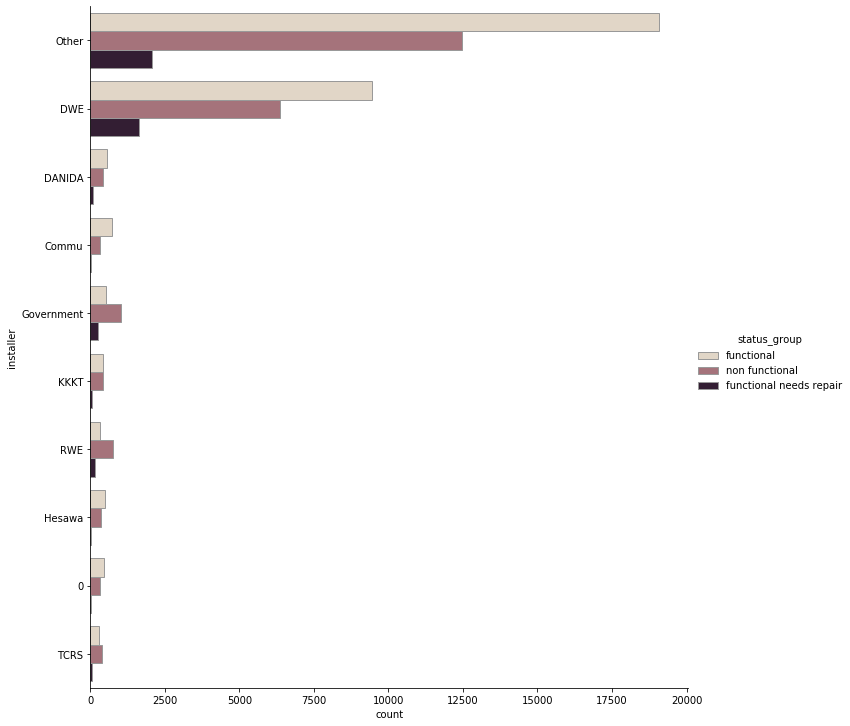

In [82]:
print(len(df_train.installer.value_counts()))
print(df_train.installer.value_counts())
plot_feature(df_train, 'installer', 'status_group')

Looks like installer could be a useful predictor as well! Look at 'Goverment' and 'RWE'. 

In [83]:
#Now for 'subvillage'. Lets find the number of categorical values in 'subvillage', and the top 10 values:
values_to_keep(df_train, 'subvillage', 10, verbose= True)

19287
Madukani           508
Shuleni            506
Majengo            502
Kati               373
Mtakuja            262
                  ... 
Mnyongo              1
Nyameni              1
Lulemba              1
Aicho Kaskazini      1
Barjomot             1
Name: subvillage, Length: 19287, dtype: int64


['Madukani',
 'Shuleni',
 'Majengo',
 'Kati',
 'Mtakuja',
 'Sokoni',
 'M',
 'Muungano',
 'Mbuyuni']

Over 19000 various values! And the top 10 do not seem to have a significant amount of the total distribution, therfore it is highly unlikely that any one of these is great predictor, but just in case lets check the distribution of the top 10. 

10
Other       56494
Madukani      508
Shuleni       506
Majengo       502
Kati          373
Mtakuja       262
Sokoni        232
M             187
Muungano      172
Mbuyuni       164
Name: subvillage, dtype: int64


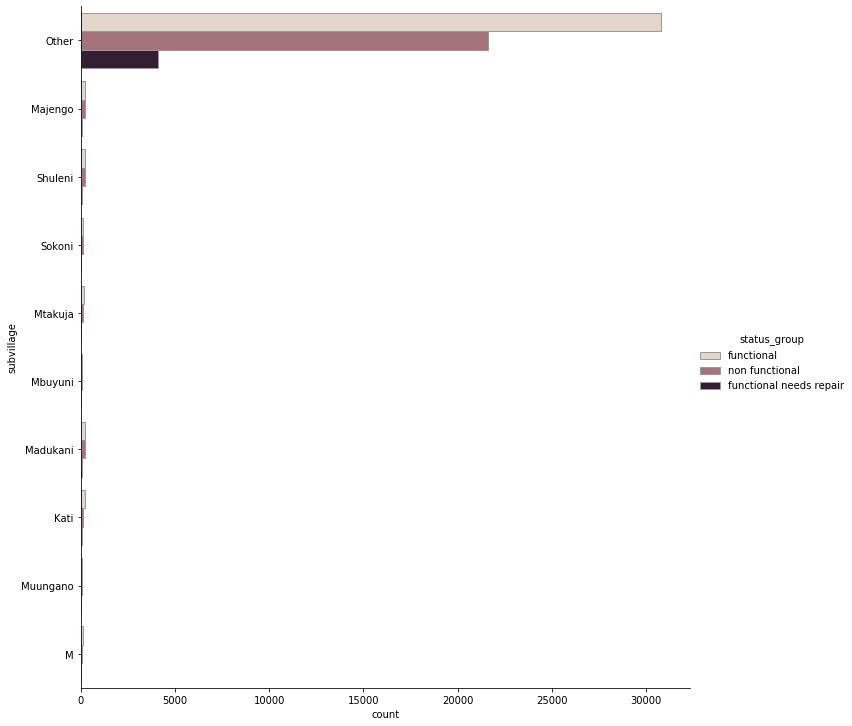

In [84]:
reduce_categorical_values(df_train, 'subvillage', 10)
print(len(df_train.subvillage.value_counts()))
print(df_train.subvillage.value_counts())
plot_feature(df_train, 'subvillage', 'status_group')

Because none of the top 10 villages (not counting 'other') have an overwhelming majority of functioning/nonfunctioning this confirms the previous assumption, the subvillage value is likely to be a poor predictor so we can just drop it.  

In [85]:
df_train = df_train.drop('subvillage', axis=1)

In [86]:
#Now for 'public_meeting'. Lets find the number of categorical values in 'public_meeting'.
values_to_keep(df_train, 'public_meeting', 10, verbose= True)

2
True     51011
False     5055
Name: public_meeting, dtype: int64


[True, False]

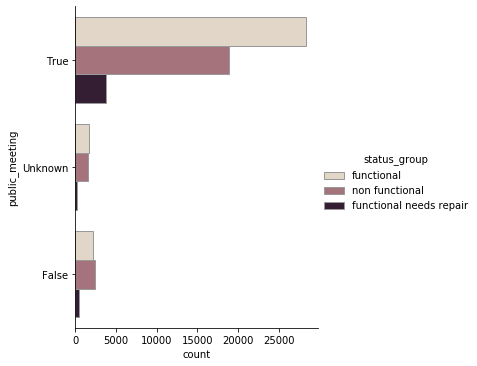

In [87]:
#Replace NaN values with "Unknown" and visualize the predictor's distribution
df_train.public_meeting.fillna(value='Unknown', inplace=True)
plot_feature(df_train, 'public_meeting', 'status_group', height=5)

In [88]:
#Now for 'scheme_management'. Lets find the number of categorical values in 'scheme_management'.
values_to_keep(df_train, 'scheme_management', 10, verbose= True)

12
VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64


['VWC',
 'WUG',
 'Water authority',
 'WUA',
 'Water Board',
 'Parastatal',
 'Private operator',
 'Company',
 'Other']

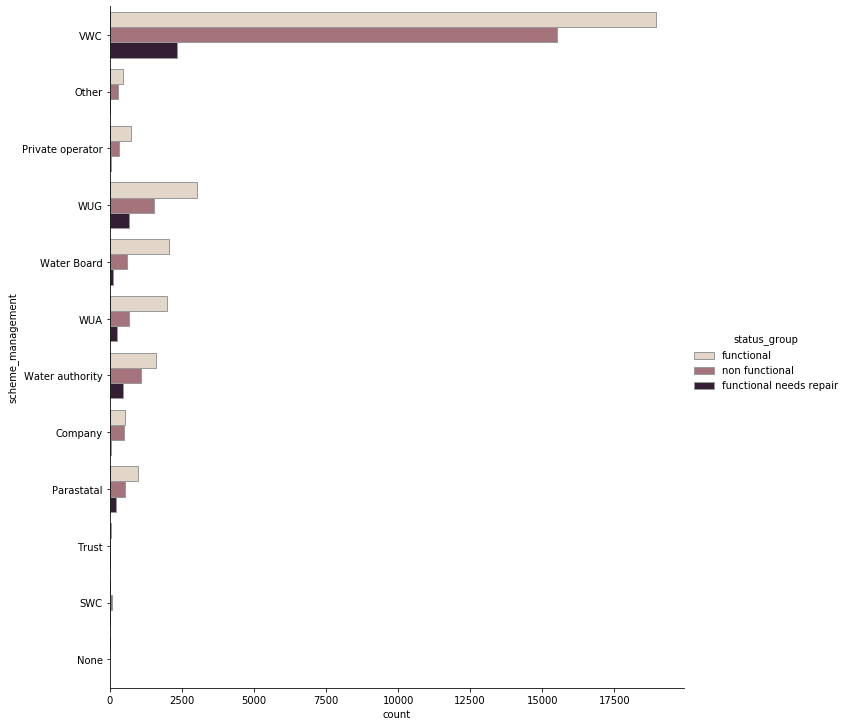

In [89]:
plot_feature(df_train, 'scheme_management', 'status_group')

Because the 10th most frequent value has mostly "non-functioning" wells, it could be a specific and precise predictor. Lets keep it. So, we'll reduce the number of values to 11, and fill in the ~3000 NaN values. 

11
VWC                 36793
WUG                  5206
Other                4644
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
SWC                    97
Trust                  72
Name: scheme_management, dtype: int64


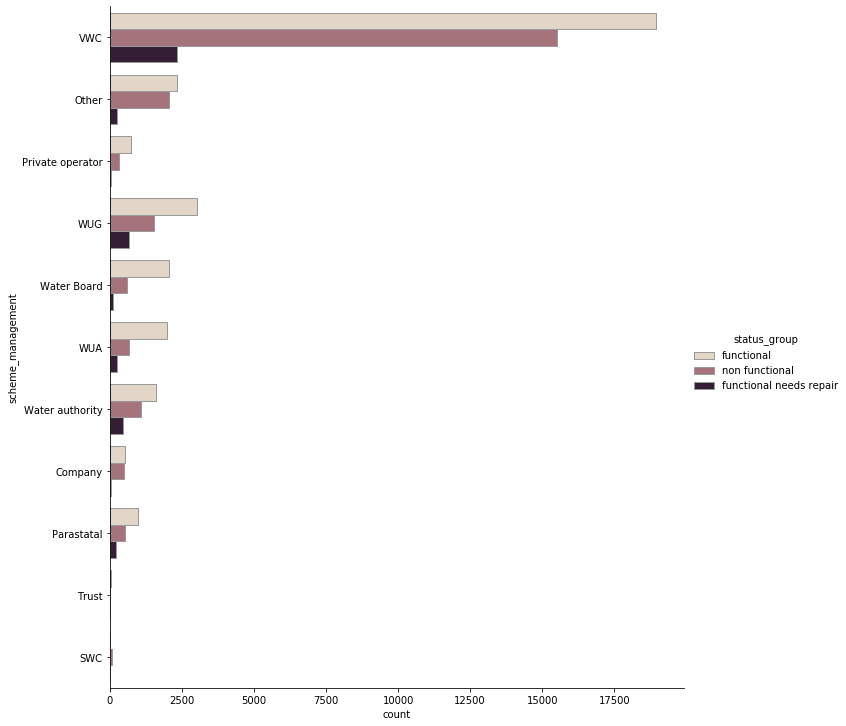

In [90]:

reduce_categorical_values(df_train, 'scheme_management', 12)
print(len(df_train.scheme_management.value_counts()))
print(df_train.scheme_management.value_counts())
plot_feature(df_train, 'scheme_management', 'status_group')

In [91]:
#Now for 'permit'. Lets find the number of categorical values in 'permit':
values_to_keep(df_train, 'permit', 10, verbose= True)

2
True     38852
False    17492
Name: permit, dtype: int64


[True, False]

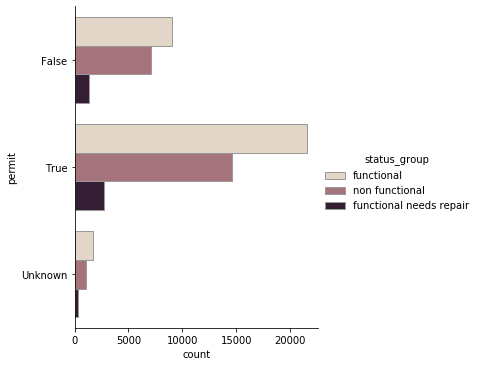

In [92]:
#Another boolean valued category. Let's replace the NaN with 'Unknown'
df_train.permit.fillna(value='Unknown', inplace=True)
plot_feature(df_train, 'permit', 'status_group', height=5)

In [93]:
df_train.isnull().sum()

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
w

Great, no more NaN values. Moving on!


### Choosing which columns to keep/drop:

There are still a lot of features. Let's sort through them and drop the less valuable predictors.

I'll be using some intuition here, as well as the data dictionary provided by Driven Data here :

https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list


In [94]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 39 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   59400 non-null object
gps_height               59400 non-null int64
installer                59400 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           59400 non-null object
recorded_by              59400 non-null object
s

In [95]:
#id is not likely to be a useful predictor:
df_train = df_train.drop('id', axis=1)

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64

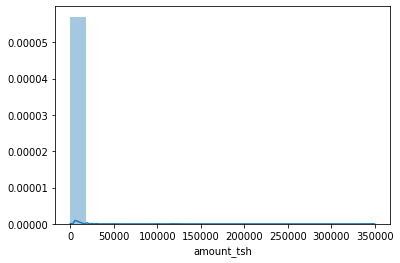

In [96]:
#amount_tsh appears to be a continuous variable. Lets look at the distribution:
sns.distplot(df_train.amount_tsh, bins = 20)
df_train.amount_tsh.value_counts()


The distribution is very skewed. I think that binning this variable could be a good approach in the future after we get a baseline model since very little flow or flow over a certain threshold could be a goood predictor. 

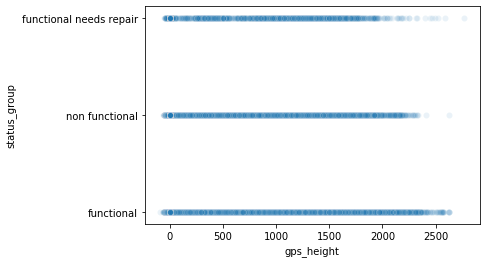

In [136]:
#lets check gps_height.  
sns.scatterplot(y="status_group",x="gps_height", data=df_train, alpha=.09)

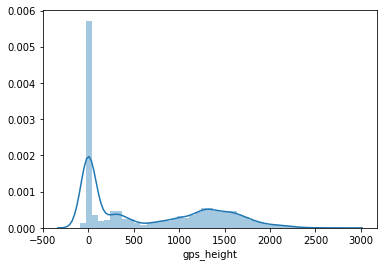

In [98]:
sns.distplot(df_train.gps_height);

Looks like we don't need to do anything with gps_height, most are at sea level, but  the altitude of the well could have some sort of effect on its function so we'll keep it as is. We may want to scale it later.

In [100]:
#We've already looked at installer when dealing with NaN, but installer '0' probably means 'Other' 
#(someone had to install it, even if it is unknown)
df_train.installer.replace(to_replace = '0', value = 'Other', inplace = True)

In [137]:
#wpt_name is not likely to be a useful predictor:
df_train = df_train.drop('wpt_name', axis=1)

/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


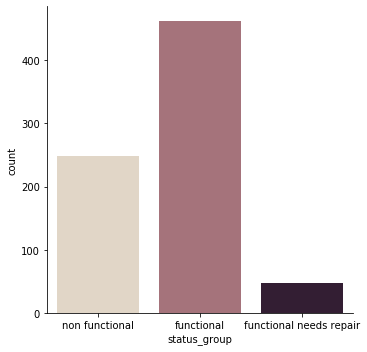

In [163]:
#num_private has no definition on the data dictionary, and is mostly 0 (58643), lets look more into it:
df_train.num_private.value_counts()

#It seems intuitive to assume that 0 means the pump is not private, and any other number means that it is private.
#Using this assumption lets categorize the pumps as 0 and 1, public/private. Lets see if this seems to be at all 
#predictive:
df_train['num_private'].loc[df_train['num_private']>0]=1
df_num_private = df_train[df_train['num_private']==1]
sns.catplot(x = 'status_group', kind = 'count', data=df_num_private, palette='ch:.25')

Though it is very small comparitively to the overall dataset it does seem that private pumps are more likely to be functional, so we'll keep it as a predictor. 

Other than lat/long, there are also 7 other geographic features. There are some of these that are very likey redundant, and some that could possibly contribute to overfitting. Lets explore them and choose which to keep.

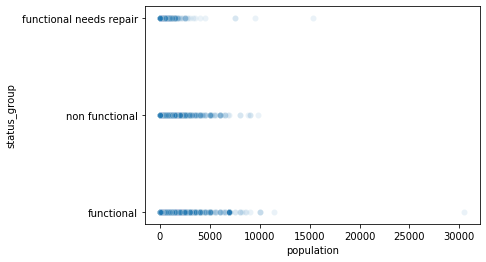

In [167]:
#lets check population around the well. It is a continious variable, and seems like it could be a contributing predictor
#so we'll include it. We may want to scale it later. 
sns.scatterplot(y="status_group",x="population", data=df_train, alpha=.09)


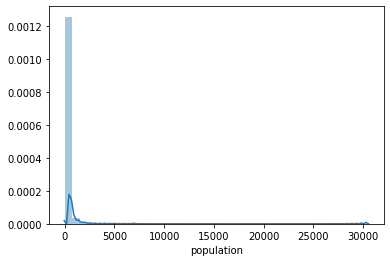

In [166]:
sns.distplot(df_train.population, bins = 40);

In [169]:
#how about recored_by:
values_to_keep(df_train, 'recorded_by', 10, verbose=True)
#All of these pumps were recorded by the same entity, so its a useless predictor, we'll drop it. 
df_train = df_train.drop('recorded_by', axis=1)

1
GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64


In [184]:
#Construction Year:
df_train.construction_year.value_counts()
#construction_year contains 20709 pumps that the year is recorded as '0'. This is a tricky one to deal with, on one 
#hand it would be nice to not have to categorize/bin the years (which we would need to do if we cast '0' as 
#unknown, on the other hand it doesnt seem like it makes much sense to fill the '0' values with the mean, median, or mode. 

#It probably makes most sense to bin the years. Thanks to 'https://github.com/mldataanalysis/Water-Pump-Classification/blob/master/Water%20Pump%201%20-%20EDA%20and%20Data%20Cleaning.ipynb'
#for the useful function to bin years. 

def construction_wrangler(row):
    if row['construction_year'] >= 1960 and row['construction_year'] < 1970:
        return '60'
    elif row['construction_year'] >= 1970 and row['construction_year'] < 1980:
        return '70'
    elif row['construction_year'] >= 1980 and row['construction_year'] < 1990:
        return '80'
    elif row['construction_year'] >= 1990 and row['construction_year'] < 2000:
        return '90'
    elif row['construction_year'] >= 2000 and row['construction_year'] < 2010:
        return '00'
    elif row['construction_year'] >= 2010:
        return '10'
    else:
        return 'unknown'
    
df_train['construction_year'] = df_train.apply(lambda row: construction_wrangler(row), axis=1)

In [192]:
#Extraction Type also seems to have 3 redundant colums.
print(df_train.extraction_type.value_counts())
print(df_train.extraction_type_class.value_counts())
print(df_train.extraction_type_group.value_counts())

#lets keep the class, because the more granular categories in the other features are so infrequent it is unlikely to 
#add much more to the model

df_train = df_train.drop('extraction_type_group', axis=1)
df_train = df_train.drop('extraction_type', axis=1)


gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64
gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64
gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono         

In [196]:
#There are two managment features. Lets choose which to keep, if either:
print(df_train.management.value_counts())
print(df_train.management_group.value_counts())

#lets keep the more granular here:
df_train = df_train.drop('management_group', axis=1)


vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64
user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64


In [200]:
#There are two payment features. Lets choose which to keep, if either:
print(df_train.payment.value_counts())
print(df_train.payment_type.value_counts())

#these are totally redundant so we'll drop one. 
df_train = df_train.drop('payment', axis=1)


never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64
never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64


In [202]:
#There are two water quality features. Lets choose which to keep, if either:
print(df_train.water_quality.value_counts())
print(df_train.quality_group.value_counts())

#lets choose the less granular to avoid overfitting:
df_train = df_train.drop('water_quality', axis=1)



soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64
good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64


In [204]:
#There are two quantity features. Lets choose which to keep, if either:
print(df_train.quantity.value_counts())
print(df_train.quantity_group.value_counts())

#once again totally redundant
df_train = df_train.drop('quantity', axis=1)


enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64
enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64


In [206]:
#There are three source features. Lets choose which to keep, if any:
print(df_train.source.value_counts())
print(df_train.source_class.value_counts())
print(df_train.source_type.value_counts())

#lets choose the source_class feature, which is the middle between too general and too granular:
df_train = df_train.drop('source', axis=1)
df_train = df_train.drop('source_type', axis=1)


spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64
groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64
spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64


In [208]:
#There are two water point features. Lets choose which to keep, if any:
print(df_train.waterpoint_type.value_counts())
print(df_train.waterpoint_type_group.value_counts())

#lets choose the one that does not differentiate between single and multiple communal standpipes:
df_train = df_train.drop('waterpoint_type', axis=1)


communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64
communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64


### Geographic Features
Great tutorial on plotting point features with geogpandas here: https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972

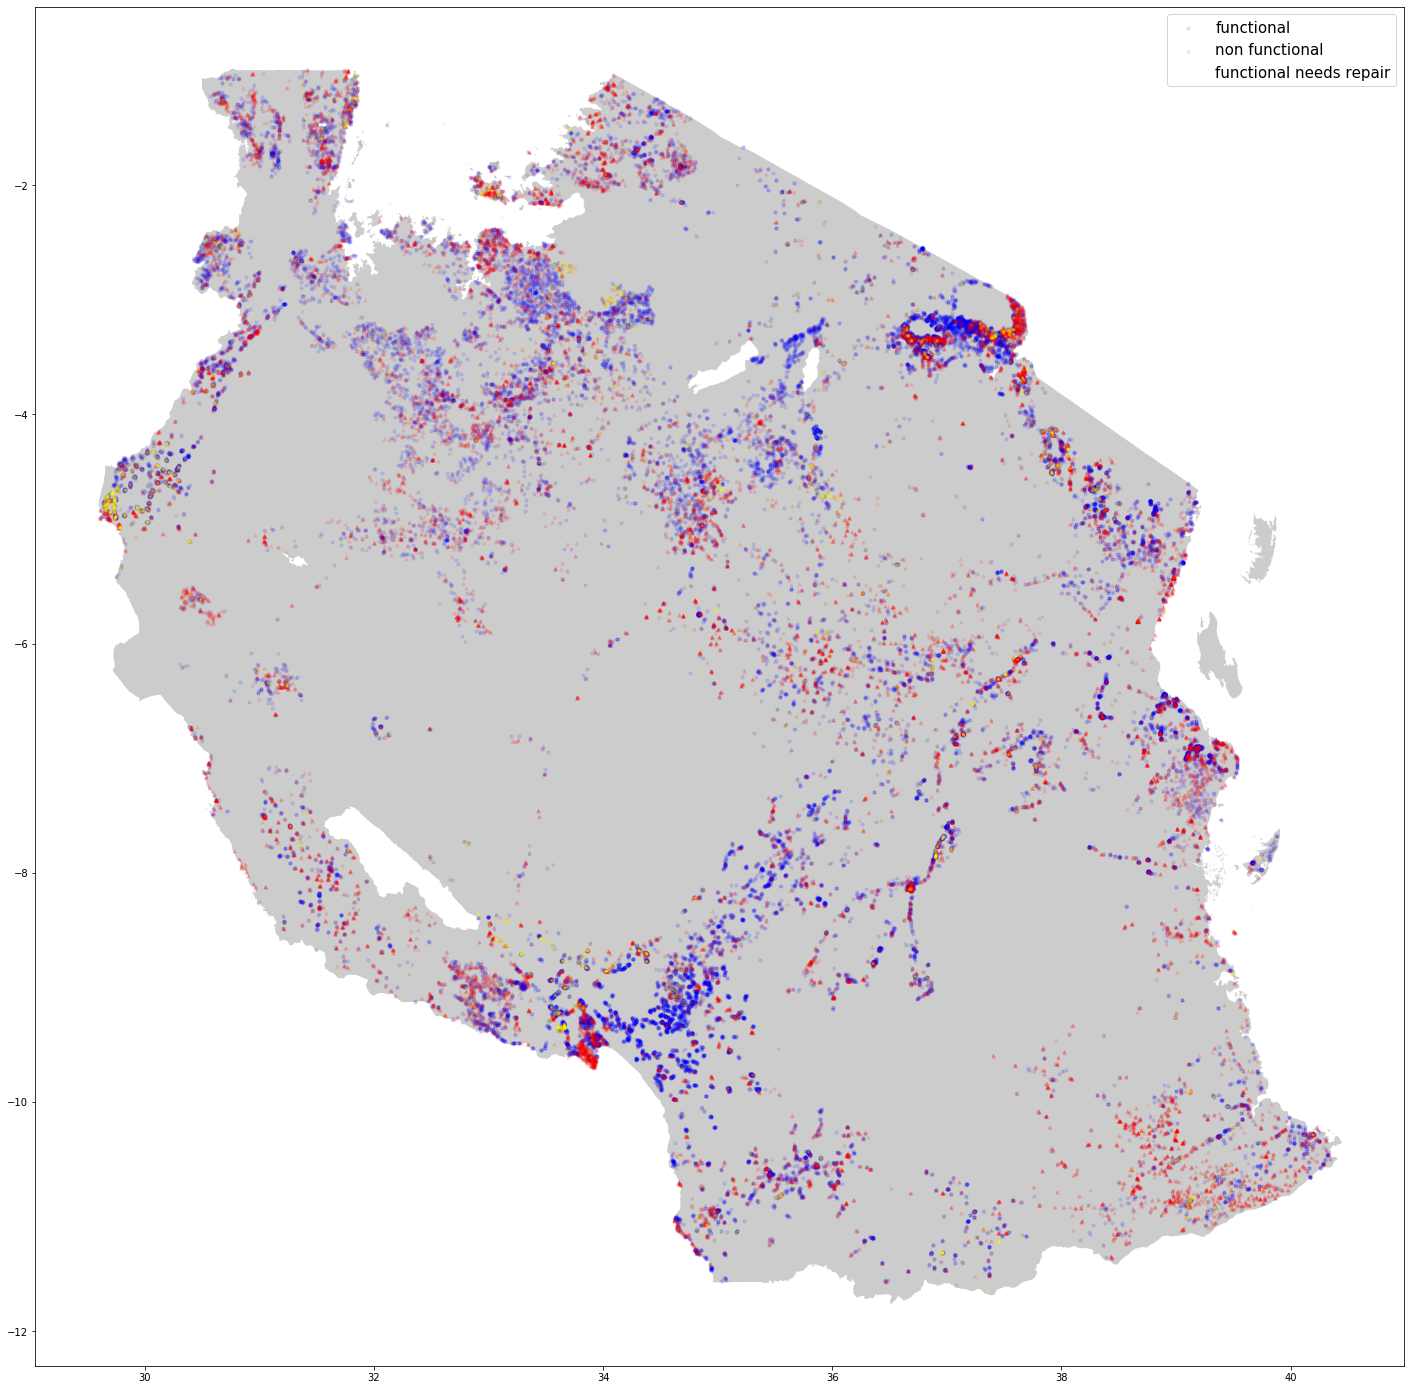

In [213]:
# Now lets look at the geography of the wells and see if we can make use of their predictive power somehow:

#import a Tanzania shape file
tanz_base = gpd.read_file('../../../data/raw/geographic/tza_admbnda_adm0_20181019.shp')

#set the WGS84 projection
crs = {'init':'espg:4326'}

#create geometric points for projecting
geometry = [Point(xy) for xy in zip( df_train['longitude'], df_train['latitude'])]
geo_df_train = gpd.GeoDataFrame(df_train, crs = crs, geometry = geometry)

#remove geographic outliers/NaNs (there were ~1800 points with longitude = 0 (Earlier mapping showed this))
geo_df_train = geo_df_train[geo_df_train.longitude != 0]

#plot the points over the Tanz base map
fig,ax = plt.subplots(figsize = (25,25))
tanz_base.plot(ax = ax, alpha = .4, color = 'grey')
geo_df_train[geo_df_train['status_group']=='functional'].plot(ax = ax, markersize = 10, 
                                                              color = 'blue', alpha = .1, marker = 'o', 
                                                              label = 'functional')
geo_df_train[geo_df_train['status_group']=='non functional'].plot(ax = ax, markersize = 10, 
                                                                  color = 'red', alpha = .1, marker = '^', 
                                                                  label = 'non functional')
geo_df_train[geo_df_train['status_group']=='functional needs repair'].plot(ax = ax, markersize = 10,
                                                                           color = 'yellow', alpha = .1, marker = '*', 
                                                                           label = 'functional needs repair')
plt.legend(prop = {'size':15})


There does look to be a possible geographic correlation with whether a well is functional. For example, in the southern part of the country there are several obvious clusters of red, and in the center of the country blue seems to dominate. They likey correlate most with population distribution, however there could be something else here such as distance from a big city or well density. Using the other geographic features in the dataset may account for these types of correlations, however this could be something to expolore later. If we have time this could be a good stretch goal.

In [198]:
df_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
